In [1]:
import scanpy as sc
import sys
sys.path.append(r"D:\Scunpair_Project\Diagonal-integration")
import mycode
adata_RNA = sc.read_h5ad(r"D:\Scunpair_Project\Dataset\scRNA+scATAC BMMC_Multiome_p10\BMMC-multiome-p10-RNA-counts.h5ad")
adata_ATAC = sc.read_h5ad(r"D:\Scunpair_Project\Dataset\scRNA+scATAC BMMC_Multiome_p10\BMMC-multiome-p10-ATAC-gam.h5ad")

In [2]:
# 取交集基因并对齐
cm_genes = sorted(list(set(adata_ATAC.var_names) & set(adata_RNA.var_names)))
adata_RNA = adata_RNA[:, cm_genes]
adata_ATAC = adata_ATAC[:, cm_genes]

# 计算高变基因
sc.pp.highly_variable_genes(adata_RNA, flavor='seurat_v3', n_top_genes=1000)
sc.pp.highly_variable_genes(adata_ATAC, flavor='seurat_v3', n_top_genes=1000)

# 取共同的高变基因
shared_genes = adata_RNA.var_names[adata_RNA.var.highly_variable | adata_ATAC.var.highly_variable]
shared_genes = list(shared_genes)

adata_RNA = adata_RNA[:,shared_genes].copy()
adata_ATAC = adata_ATAC[:,shared_genes].copy()

sc.pp.normalize_total(adata_RNA)
sc.pp.log1p(adata_RNA)

sc.pp.normalize_total(adata_ATAC)
sc.pp.log1p(adata_ATAC)

sc.pp.scale(adata_RNA, max_value=10)
sc.pp.scale(adata_ATAC, max_value=10)

c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:174: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:174: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
c:\Users\Administrator\miniconda3\envs\mycode\lib\functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
c:\Users\Administrator\miniconda3\envs\mycode\lib\functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [3]:
model = mycode.Model(adata_RNA, adata_ATAC, batch_size=500, 
                           training_steps=10001, seed=1234, celltype_col='cell_type',source_col=None,
                            n_latent=16, lambdaRecon = 10.0, lambdaLA = 10.0, loss_type='MSE',
                            lambdaAlign = 1.0, lambdamGAN = 1.0, lambdabGAN = 0.0, n_KNN = 30, lambdaGeo=0.5, mode = 'strong', use_prior = True, link_feat_num=len(shared_genes))

In [4]:
model.train()
model.eval()

Training started at: Tue Sep 30 16:17:10 2025
Step 0 | loss_Recon: 19.7124 | loss_LA: 42.0238 | loss_Align: 0.8993 | loss_Geo: 0.4160 | loss_mGAN vs loss_mDis: -1.3961 vs 1.3925 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 1000 | loss_Recon: 16.0740 | loss_LA: 0.0543 | loss_Align: 0.0380 | loss_Geo: 0.0186 | loss_mGAN vs loss_mDis: -1.3563 vs 1.3597 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 2000 | loss_Recon: 15.7687 | loss_LA: 0.0458 | loss_Align: 0.0351 | loss_Geo: 0.0170 | loss_mGAN vs loss_mDis: -1.3692 vs 1.3721 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 3000 | loss_Recon: 15.6963 | loss_LA: 0.0393 | loss_Align: 0.0370 | loss_Geo: 0.0175 | loss_mGAN vs loss_mDis: -1.3726 vs 1.3751 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 4000 | loss_Recon: 15.1914 | loss_LA: 0.0359 | loss_Align: 0.0360 | loss_Geo: 0.0175 | loss_mGAN vs loss_mDis: -1.3670 vs 1.3688 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 5000 | loss_Recon: 15.7146 | loss_LA: 0.0380 | loss_Align: 0.

In [5]:
import anndata as ad
import pandas as pd
adata_integrated = ad.AnnData(X=model.latent)
adata_integrated.obs = pd.concat([adata_RNA.obs, adata_ATAC.obs])
adata_integrated.obs['modality'] = ['RNA'] * adata_RNA.shape[0] + ['ATAC'] * adata_ATAC.shape[0]

In [6]:
sc.pp.neighbors(adata_integrated)
sc.tl.umap(adata_integrated, min_dist=0.3)

c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DSBN

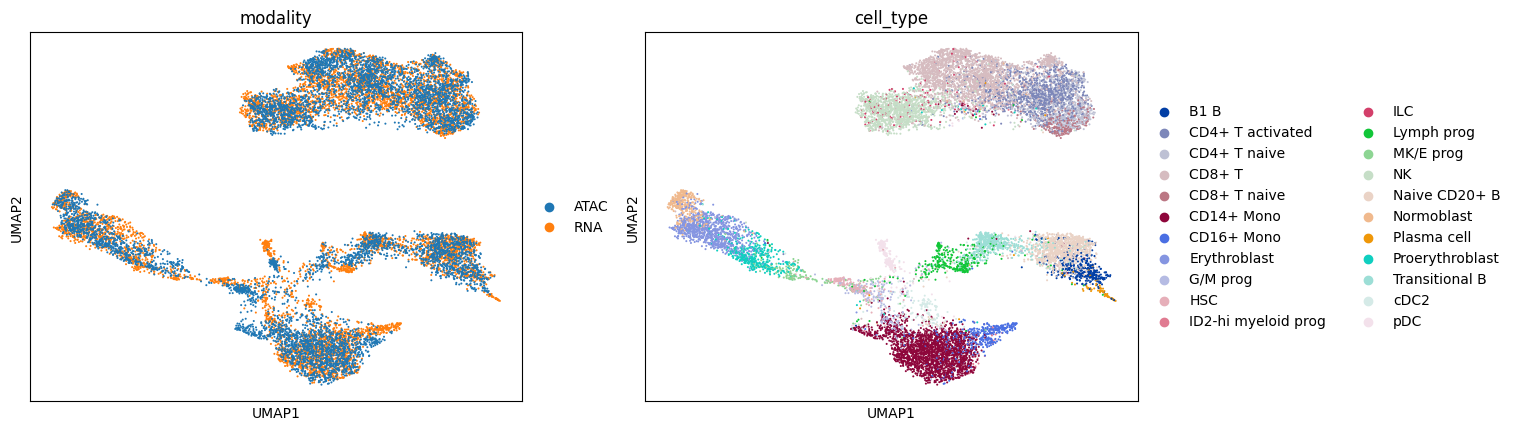

In [ ]:
sc.pl.umap(adata_integrated, color=['modality','cell_type'])

Prefix

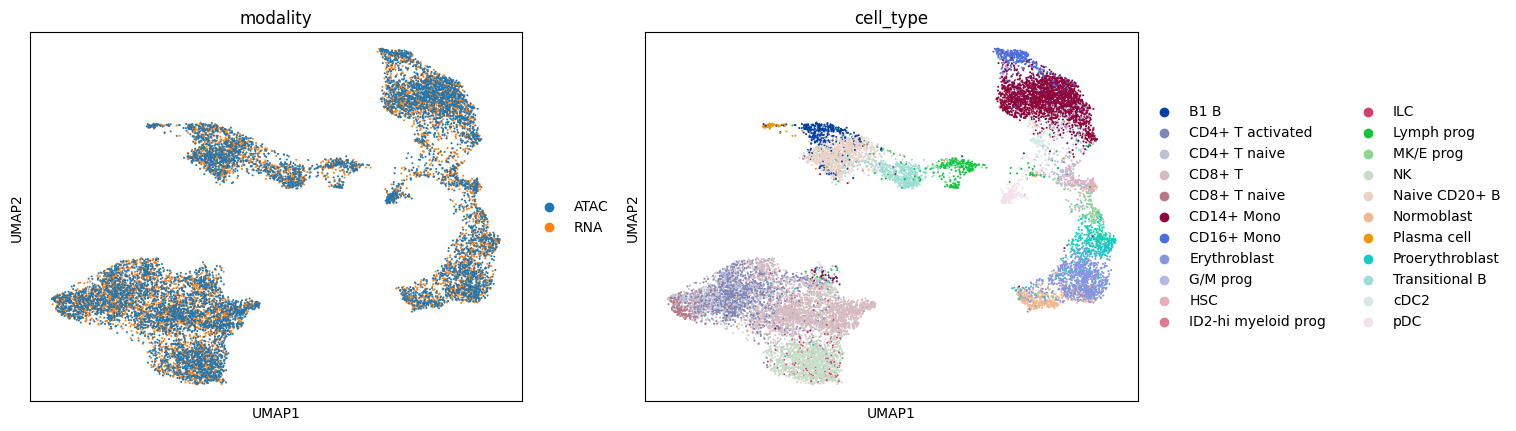

In [7]:
sc.pl.umap(adata_integrated, color=['modality','cell_type'])